In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection-dataset-csv/Fraud Detection Dataset.csv


In [2]:
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('/kaggle/input/fraud-detection-dataset-csv/Fraud Detection Dataset.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [4]:
df.columns

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Time_of_Transaction', 'Device_Used', 'Location',
       'Previous_Fraudulent_Transactions', 'Account_Age',
       'Number_of_Transactions_Last_24H', 'Payment_Method', 'Fraudulent'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    51000 non-null  object 
 1   User_ID                           51000 non-null  int64  
 2   Transaction_Amount                48480 non-null  float64
 3   Transaction_Type                  51000 non-null  object 
 4   Time_of_Transaction               48448 non-null  float64
 5   Device_Used                       48527 non-null  object 
 6   Location                          48453 non-null  object 
 7   Previous_Fraudulent_Transactions  51000 non-null  int64  
 8   Account_Age                       51000 non-null  int64  
 9   Number_of_Transactions_Last_24H   51000 non-null  int64  
 10  Payment_Method                    48531 non-null  object 
 11  Fraudulent                        51000 non-null  int64  
dtypes: f

EDA

Fraudulent
0    48490
1     2510
Name: count, dtype: int64
Class ratio: 0.051763250154671064


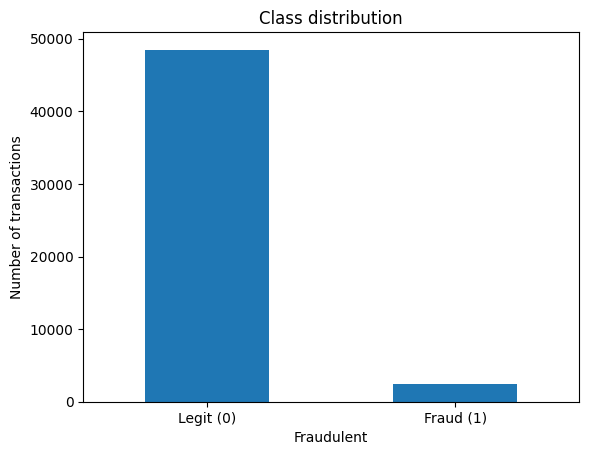

In [6]:
target_col = "Fraudulent"

class_counts = df[target_col].value_counts()
print(class_counts)
print("Class ratio:", class_counts[1] / class_counts[0])

plt.figure()
class_counts.plot(kind="bar")
plt.xticks([0, 1], ["Legit (0)", "Fraud (1)"], rotation=0)
plt.title("Class distribution")
plt.ylabel("Number of transactions")
plt.show()

Distribution of transaction amounts

In [7]:
df.columns.tolist()


['Transaction_ID',
 'User_ID',
 'Transaction_Amount',
 'Transaction_Type',
 'Time_of_Transaction',
 'Device_Used',
 'Location',
 'Previous_Fraudulent_Transactions',
 'Account_Age',
 'Number_of_Transactions_Last_24H',
 'Payment_Method',
 'Fraudulent']

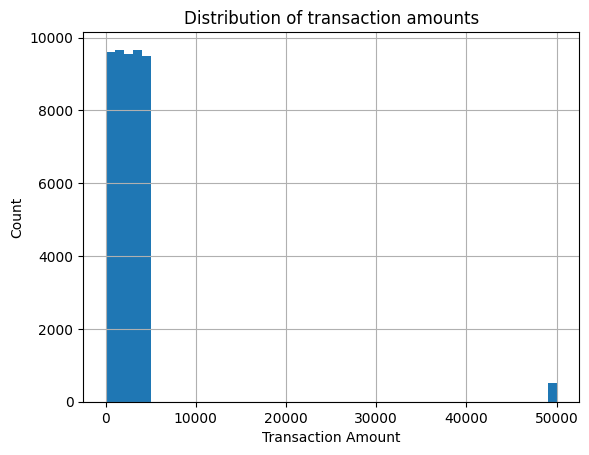

In [8]:
plt.figure()
df['Transaction_Amount'].hist(bins=50)
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.title("Distribution of transaction amounts")
plt.show()

fraud vs non-fraud distribution by amount

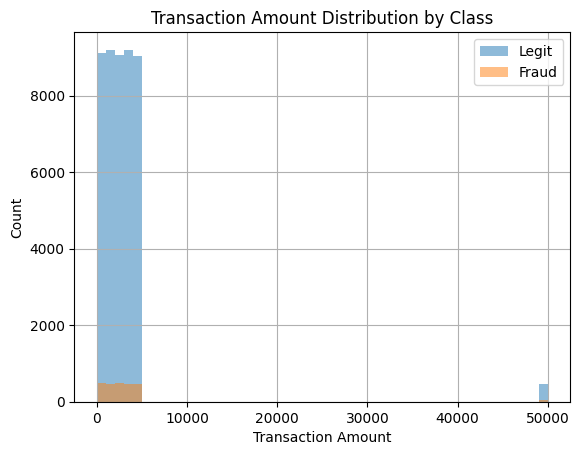

In [9]:
plt.figure()
df[df['Fraudulent'] == 0]['Transaction_Amount'].hist(bins=50, alpha=0.5, label='Legit')
df[df['Fraudulent'] == 1]['Transaction_Amount'].hist(bins=50, alpha=0.5, label='Fraud')
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.title("Transaction Amount Distribution by Class")
plt.legend()
plt.show()

fraud rate by categorical features


=== Transaction_Type ===
Fraud rate (top 10):
Transaction_Type
Online Purchase    0.051912
POS Payment        0.050069
Bill Payment       0.049516
Bank Transfer      0.048073
ATM Withdrawal     0.046537
Name: Fraudulent, dtype: float64

Counts (top 10):
Transaction_Type
Bill Payment       10340
Bank Transfer      10276
ATM Withdrawal     10164
POS Payment        10126
Online Purchase    10094
Name: count, dtype: int64


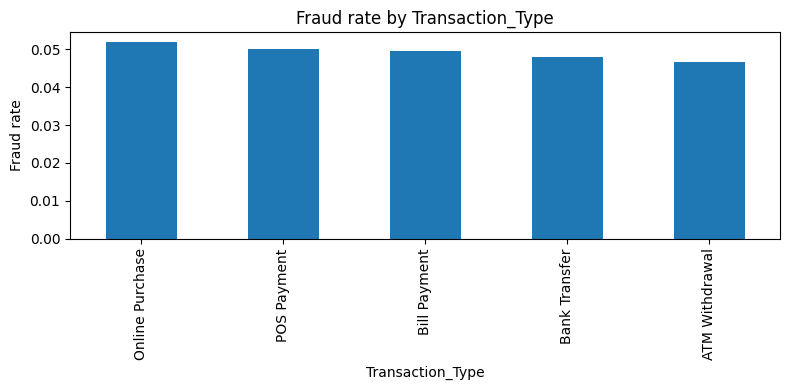


=== Payment_Method ===
Fraud rate (top 10):
Payment_Method
UPI               0.051485
Credit Card       0.049287
Net Banking       0.049203
Debit Card        0.048466
Invalid Method    0.047712
Name: Fraudulent, dtype: float64

Counts (top 10):
Payment_Method
UPI               11887
Debit Card        11802
Net Banking       11666
Credit Card       11646
Invalid Method     1530
Name: count, dtype: int64


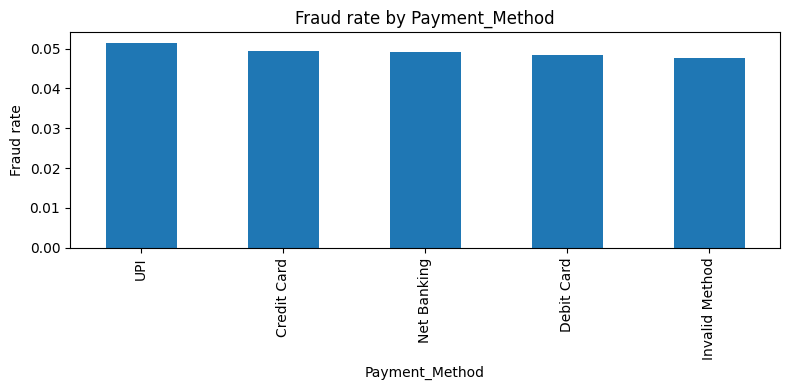


=== Device_Used ===
Fraud rate (top 10):
Device_Used
Mobile            0.051620
Unknown Device    0.049020
Desktop           0.047357
Tablet            0.046767
Name: Fraudulent, dtype: float64

Counts (top 10):
Device_Used
Desktop           15795
Mobile            15614
Tablet            15588
Unknown Device     1530
Name: count, dtype: int64


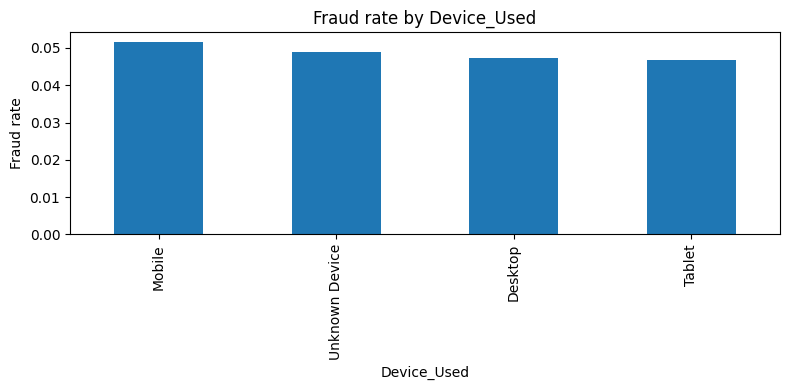


=== Location ===
Fraud rate (top 10):
Location
Chicago          0.055016
Los Angeles      0.051564
Boston           0.050415
Miami            0.049741
San Francisco    0.049624
New York         0.047463
Houston          0.046758
Seattle          0.043578
Name: Fraudulent, dtype: float64

Counts (top 10):
Location
Boston           6149
New York         6110
Seattle          6104
Chicago          6071
Houston          6031
Los Angeles      6012
Miami            5991
San Francisco    5985
Name: count, dtype: int64


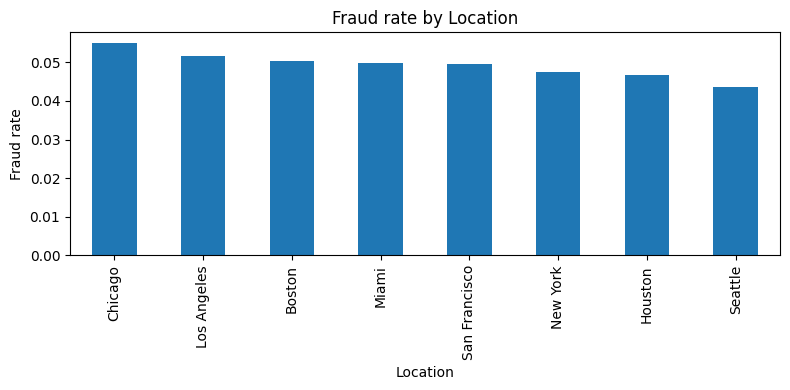

In [10]:
def plot_fraud_rate_by(col):
    rates = df.groupby(col)[target_col].mean().sort_values(ascending=False)
    counts = df[col].value_counts()
    
    print(f"\n=== {col} ===")
    print("Fraud rate (top 10):")
    print(rates.head(10))
    print("\nCounts (top 10):")
    print(counts.head(10))
    
    plt.figure(figsize=(8, 4))
    rates.plot(kind="bar")
    plt.ylabel("Fraud rate")
    plt.title(f"Fraud rate by {col}")
    plt.tight_layout()
    plt.show()

for col in [
    "Transaction_Type",
    "Payment_Method",
    "Device_Used",
    "Location"
]:
    if col in df.columns:
        plot_fraud_rate_by(col)

numeric correlations

Fraudulent                          1.000000
Time_of_Transaction                 0.007035
Account_Age                         0.006203
Transaction_Amount                  0.005507
Previous_Fraudulent_Transactions    0.001136
Number_of_Transactions_Last_24H    -0.003877
Name: Fraudulent, dtype: float64


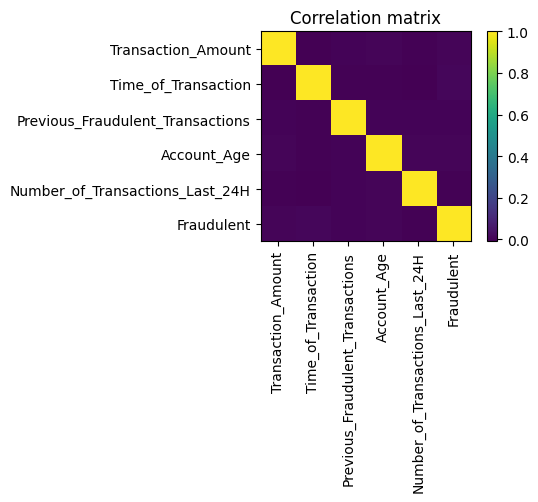

In [11]:
numeric_cols = [
    "Transaction_Amount",
    "Time_of_Transaction",
    "Previous_Fraudulent_Transactions",
    "Account_Age",
    "Number_of_Transactions_Last_24H",
]

numeric_cols = [c for c in numeric_cols if c in df.columns]

corr = df[numeric_cols + [target_col]].corr()
print(corr[target_col].sort_values(ascending=False))

plt.figure(figsize=(6, 5))
im = plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(im)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

Feature Engineering & Preprocessing

In [12]:
# Drop identifiers that shouldn't be used as features
drop_cols = ["Transaction_ID", "User_ID"]
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=c)

target_col = "Fraudulent"
y = df[target_col]
X = df.drop(columns=[target_col])

In [13]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Categorical: ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
Numeric: ['Transaction_Amount', 'Time_of_Transaction', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H']


In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Rebuild X, y just to be safe
target_col = "Fraudulent"
y = df[target_col]
X = df.drop(columns=[target_col])

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

# Numeric: impute median, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute most frequent, then one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

Categorical: ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
Numeric: ['Transaction_Amount', 'Time_of_Transaction', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H']


Train / Test Split

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Logistic Regression

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

log_reg_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Transaction_Amount',
                                                   'Time_of_Transaction',
                                                   'Previous_Fraudulent_Transactions',
                                                   'Account_Age',
                                                   'Number_of_Transactions_Last_24H']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Transaction_Type',
                                                   'Device_Used', 'Location',
                                                   'Payment_Method'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

print("📌 LOGISTIC REGRESSION — CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_lr, digits=4))

print("📌 ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

print("📌 CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_lr))

📌 LOGISTIC REGRESSION — CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9495    0.5390    0.6876      9698
           1     0.0477    0.4462    0.0862       502

    accuracy                         0.5344     10200
   macro avg     0.4986    0.4926    0.3869     10200
weighted avg     0.9051    0.5344    0.6580     10200

📌 ROC-AUC: 0.49211054318506553
📌 CONFUSION MATRIX:
[[5227 4471]
 [ 278  224]]


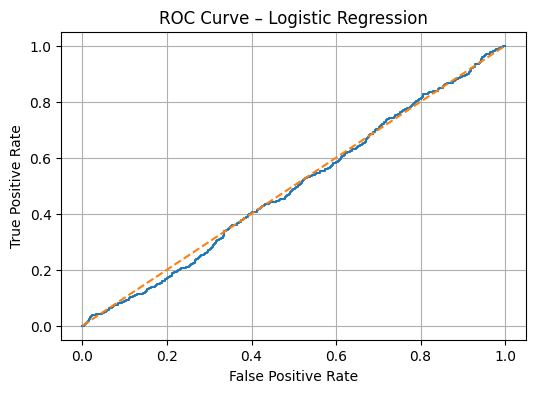

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.grid()
plt.show()

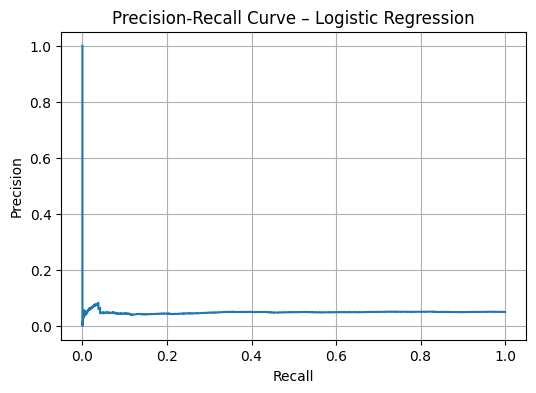

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_lr)

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Logistic Regression")
plt.grid()
plt.show()

Stronger Model – Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Transaction_Amount',
                                                   'Time_of_Transaction',
                                                   'Previous_Fraudulent_Transactions',
                                                   'Account_Age',
                                                   'Number_of_Transactions_Last_24H']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Transaction_Type',
                                                   'Device_Used', 'Location',
                                                   'Payment_Method'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [21]:
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("📌 RANDOM FOREST — CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_rf, digits=4))

print("📌 ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

print("📌 CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_rf))

📌 RANDOM FOREST — CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9519    1.0000    0.9754      9698
           1     1.0000    0.0239    0.0467       502

    accuracy                         0.9520     10200
   macro avg     0.9760    0.5120    0.5110     10200
weighted avg     0.9543    0.9520    0.9297     10200

📌 ROC-AUC: 0.5290311223655594
📌 CONFUSION MATRIX:
[[9698    0]
 [ 490   12]]


In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

thresholds = np.linspace(0.01, 0.99, 99)

results = []
for t in thresholds:
    y_pred_t = (y_proba_rf >= t).astype(int)
    results.append([
        t,
        precision_score(y_test, y_pred_t, zero_division=0),
        recall_score(y_test, y_pred_t, zero_division=0),
        f1_score(y_test, y_pred_t, zero_division=0)
    ])

results_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])
results_df.head()

,threshold,precision,recall,f1
0,0.01,0.049559,0.986056,0.094376
1,0.02,0.050488,0.906375,0.095649
2,0.03,0.051177,0.749004,0.095808
3,0.04,0.051557,0.573705,0.094612
4,0.05,0.053123,0.430279,0.094571


In [23]:
best = results_df[results_df["recall"] >= 0.80].sort_values("f1", ascending=False).head(1)
best

,threshold,precision,recall,f1
1,0.02,0.050488,0.906375,0.095649


In [24]:
best_t = float(best["threshold"].values[0])
y_pred_best = (y_proba_rf >= best_t).astype(int)

print("📌 THRESHOLD-TUNED MODEL:")
print(classification_report(y_test, y_pred_best, digits=4))
print(confusion_matrix(y_test, y_pred_best))

📌 THRESHOLD-TUNED MODEL:
              precision    recall  f1-score   support

           0     0.9604    0.1177    0.2096      9698
           1     0.0505    0.9064    0.0956       502

    accuracy                         0.1565     10200
   macro avg     0.5055    0.5120    0.1526     10200
weighted avg     0.9157    0.1565    0.2040     10200

[[1141 8557]
 [  47  455]]
